In [1]:
#%matplotlib inline
#%matplotlib gtk
import sys
sys.path.insert(0, '../')
from pytest import approx
import fconcrete as fc
#import fconcrete
#from fconcrete import helpers, duplicated, Material, e, Beam, Node, Loads, Nodes, Load,Material, ConcreteBeam, SingleBeamElement, Rectangle, Concrete, Section, ConcreteSteels
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(precision=3, suppress=True, linewidth=3000)

#from math import log

# Tension in MPa
# length in cm
# Shear in kN

In [2]:
material = fc.Concrete(fck='30 MPa', aggressiveness=2)
section = fc.Rectangle(25,56, material)

f1 = fc.Load.UniformDistributedLoad(-0.1622, x_begin=0, x_end=113)
f2 = fc.Load.UniformDistributedLoad(-0.4994, x_begin=113, x_end=583)
f3 = fc.Load.UniformDistributedLoad(-0.4196, x_begin=583, x_end=1188)

n1 = fc.Node.SimpleSupport(x=0)
n2 = fc.Node.SimpleSupport(x=113)
n3 = fc.Node.SimpleSupport(x=583)
n4 = fc.Node.SimpleSupport(x=1188)

bar1 = fc.SingleBeamElement([n1, n2], section)
bar2 = fc.SingleBeamElement([n2, n3], section)
bar3 = fc.SingleBeamElement([n3, n4], section)

fc.config.available_material = {
    "concrete_steel_bars":fc.AvailableConcreteSteelBar(diameters=[8]),
    "steel_bar_surface_type":"ribbed"
}
    
beam = fc.ConcreteBeam(
    loads = [f1, f2, f3],
    beam_elements = [bar1, bar2, bar3],
    #bar_steel_max_removal = 2,
)
self = beam
steel_bars = self.steel_bars

interspace [147.797 455.122]
begin e end
148.31081786786788 454.6081109009009
148.31081786786788 454.6081109009009
lbmin 10
lb 26.685840094075008
lb_nec 19.026219575445886
alpha lb As_calc As_ef fbd
1 26.685840094075008 1.7824265142462419 2.5 0.3258526673044001
diameter 0.8
----------
interspace [ 681.068 1214.5  ]
begin e end
902.9324276776777 992.1216153653653
902.9324276776777 992.1216153653653
lbmin 10
lb 26.685840094075008
lb_nec 24.615115416820544
alpha lb As_calc As_ef fbd
1 26.685840094075008 5.534421700057877 6.0 0.3258526673044001
diameter 0.8
----------
interspace [-26.5   200.635]
begin e end
84.43244101101101 140.66217024024024
84.43244101101101 140.66217024024024
lbmin 11.436788611746431
lb 38.12262870582144
lb_nec 31.16660834361911
alpha lb As_calc As_ef fbd
1 38.12262870582144 -2.0438391449944713 -2.5 0.22809686711308005
diameter -0.8
----------
interspace [402.284 734.068]
begin e end
547.8783787087087 617.1891887987988
547.8783787087087 617.1891887987988
lbmin 11.4367

### Decaleged Behaviour

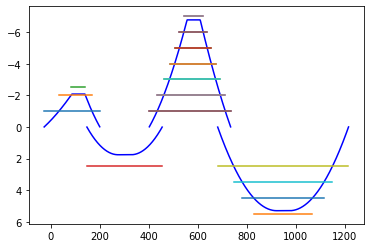

In [4]:
x, yp, yn = beam.getSteelAreaDiagram()
plt.plot(x, yp, 'b-')
plt.plot(x, yn, 'b-')
self.steel_bars.plot()

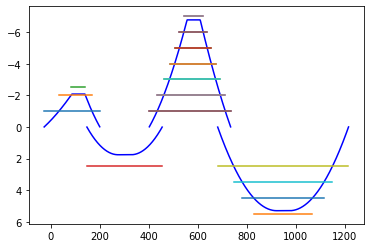

In [8]:
x, yp, yn = beam.getSteelAreaDiagram()
plt.plot(x, yp, 'b-')
plt.plot(x, yn, 'b-')
self.steel_bars.plot()

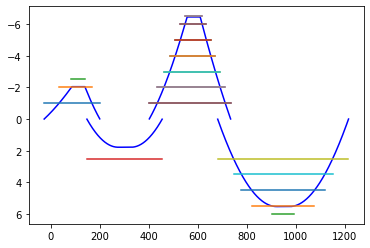

In [8]:
x, yp, yn = beam.getSteelAreaDiagram()
plt.plot(x, yp, 'b-')
plt.plot(x, yn, 'b-')
self.steel_bars.plot()

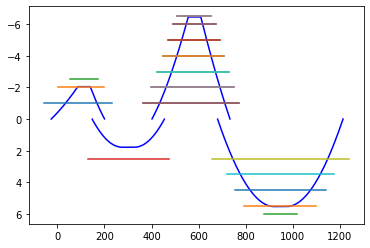

In [3]:
x, yp, yn = beam.getSteelAreaDiagram()
plt.plot(x, yp, 'b-')
plt.plot(x, yn, 'b-')
self.steel_bars_with_anchor_length.plot()

In [3]:
self.steel_bars

[{'long_begin': -25.310800830830832, 'long_end': 200.12162869869871, 'quantity': 2, 'diameter': -0.8, 'interspace': (-26.49999, 200.63514131131132), 'quantity_accumulated': 2, 'area_accumulated': -1.0, 'area': -1.0, 'fyd': 43.47826086956522}
 {'long_begin': 34.48649590590591, 'long_end': 168.01352113113114, 'quantity': 2, 'diameter': -0.8, 'interspace': (-26.49999, 200.63514131131132), 'quantity_accumulated': 4, 'area_accumulated': -2.0, 'area': -1.0, 'fyd': 43.47826086956522}
 {'long_begin': 84.43244101101101, 'long_end': 140.66217024024024, 'quantity': 1, 'diameter': -0.8, 'interspace': (-26.49999, 200.63514131131132), 'quantity_accumulated': 5, 'area_accumulated': -2.5, 'area': -0.5, 'fyd': 43.47826086956522}
 {'long_begin': 148.31081786786788, 'long_end': 454.6081109009009, 'quantity': 5, 'diameter': 0.8, 'interspace': (147.79730525525525, 455.1216235135135), 'quantity_accumulated': 5, 'area_accumulated': 2.5, 'area': 2.5, 'fyd': 43.47826086956522}
 {'long_begin': 402.7973000700700

In [4]:
self.steel_bars_with_anchor_length

[{'long_begin': -56.477409174449946, 'long_end': 231.28823704231783, 'quantity': 2, 'diameter': -0.8, 'interspace': (-26.49999, 200.63514131131132), 'quantity_accumulated': 2, 'area_accumulated': -1.0, 'area': -1.0, 'fyd': 43.47826086956522}
 {'long_begin': 3.3198875622868016, 'long_end': 199.18012947475026, 'quantity': 2, 'diameter': -0.8, 'interspace': (-26.49999, 200.63514131131132), 'quantity_accumulated': 4, 'area_accumulated': -2.0, 'area': -1.0, 'fyd': 43.47826086956522}
 {'long_begin': 53.2658326673919, 'long_end': 171.82877858385936, 'quantity': 1, 'diameter': -0.8, 'interspace': (-26.49999, 200.63514131131132), 'quantity_accumulated': 5, 'area_accumulated': -2.5, 'area': -0.5, 'fyd': 43.47826086956522}
 {'long_begin': 148.31081786786788, 'long_end': 454.6081109009009, 'quantity': 5, 'diameter': 0.8, 'interspace': (147.79730525525525, 455.1216235135135), 'quantity_accumulated': 5, 'area_accumulated': 2.5, 'area': 2.5, 'fyd': 43.47826086956522}
 {'long_begin': 364.8765211834858